In [1]:
import sys
sys.path.append("../")

In [2]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
from functools import partial
from model_code import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmp2l0qqod8\tensorboard_logs


In [5]:
dataset_folder = "../dataset/tcb_dataset_0_2_3_2018_2024_test_2024_2024_with_ema_macd_trend"

In [6]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [7]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

In [8]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

In [9]:
dataset_train

<_ConcatenateDataset element_spec=(TensorSpec(shape=(6, 1), dtype=tf.float64, name=None), TensorSpec(shape=(6, 1), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(6, 4), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [10]:
def model_5_biLSTM_with_ema_macd_trend(image_shape, days_result, days_of_ema_9=2, days_of_macd_history=2):
    trend_type_input = keras.layers.Input(shape=(1,), name="trend_type_input")
    x1 = keras.layers.Dense(8, activation='relu')(trend_type_input)
    
    image_input = keras.layers.Input(shape=image_shape, name="image_input")
    x2 = keras.layers.Conv2D(8, (2, 2), activation='relu')(image_input)
    x2 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x2)
    x2 = keras.layers.Flatten()(image_input)
    x2 = keras.layers.Dense(64, activation='relu')(x2)
    x2 = keras.layers.Dropout(0.1)(x2)
    
    ema_9_input = keras.layers.Input(shape=(days_of_ema_9,), name="ema_9_input")
    x3 = keras.layers.Dense(8, activation='relu')(ema_9_input)
    
    macd_history_input = keras.layers.Input(shape=(days_of_macd_history,), name="macd_history_input")
    x4 = keras.layers.Dense(8, activation='relu')(macd_history_input)
    
    combined = keras.layers.concatenate([x3, x4, x1, x2])
    
    z = keras.layers.Dense(64, activation='relu')(combined)
    z = keras.layers.Dropout(0.1)(z)
    z = keras.layers.Dense(64, activation='relu')(z)
    
    input_lstm = keras.layers.RepeatVector(days_result)(z)
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, activation="tanh", return_sequences=True))(input_lstm)
    lstm = keras.layers.Dropout(0.1)(lstm)
    lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, activation="tanh", return_sequences=True))(lstm)
    lstm = keras.layers.Dropout(0.1)(lstm)
    output_lstm = keras.layers.TimeDistributed(keras.layers.Dense(2))(lstm)
    
    model = keras.models.Model(inputs=[ema_9_input, macd_history_input, trend_type_input, image_input], outputs=output_lstm)
    
    return model, "model_5_bi2LSTM_ema_macd_trend"


In [11]:
function_transform_origin = get_open_close_prices_percent_of_last_days_result_for_ema_macd_trend_dataset
model_function = model_5_biLSTM_with_ema_macd_trend
function_evaluate_old_model = evaluate_fpt_model_5_biLSTM_with_trend_type_2023_2024
image_shape = get_image_shape(dataset_train, index_of_image=3)
model, model_name = model_function(image_shape, days_result)

In [12]:
batch_size = 64
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
max_epochs = int(input(f"max_epochs = "))
metric_mae_name = "mae"
metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
metric_mse_name = "mse"
metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
start_learning_rate = 0.01
shuffle_buffer = 300
print(f"{STEPS_PER_EPOCH=}")
number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
number_epochs_to_wait = int(input("number_epochs_to_wait = "))

STEPS_PER_EPOCH=10


In [13]:
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

STEPS_PER_EPOCH=10
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=8
number_epochs_to_wait=10


In [14]:
model_name

'model_5_bi2LSTM_ema_macd_trend'

In [15]:
(total_data_train, total_data_test)

(638, 77)

In [16]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(function_transform_origin, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [17]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [18]:
(len(dataset_train_3), len(dataset_test_3))

(10, 2)

In [19]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True


class SaveModelCallback(keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        folder_tmp = f"{self.save_path}/tmp_model"
        file_name = f"{folder_tmp}/model_tmp_{epoch}.keras"
        self.model.save(file_name)  # Lưu toàn bộ model
        

class TrackingLossCallback(keras.callbacks.Callback):
    def __init__(self, metric_name):
        super().__init__()
        self.list_epochs = []
        self.list_loss = []
        self.metric_name = metric_name
        self.loss_key = f"val_{self.metric_name}"

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        self.list_epochs.append(epoch)
        self.list_loss.append(logs.get(self.loss_key))
    
    def get_df_result(self):
        df = pd.DataFrame({
            "epoch": self.list_epochs,
            self.loss_key: self.list_loss
        })
        df.sort_values(self.loss_key, inplace=True)
        return df

In [20]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)

tracking_loss_callback = TrackingLossCallback(metric_mse_name)
def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        SaveModelCallback(dataset_folder),
        tracking_loss_callback,
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [21]:
# Ví dụ
all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
evaluate_all_models_in_dataset_folder(
    all_models_folder_path, 
    dataset_test_2,
    days_result
)

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2914 - mae: 0.8200 - mse: 1.2914
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.2846 - mae: 0.8201 - mse: 1.2846 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.2599 - mae: 0.8226 - mse: 1.2599
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2662 - mae: 0.8217 - mse: 1.2662 


,model_name,mse,mae
0,model_5_bi2LSTM_ema_macd_trend,1.269986,0.816022
1,model_5_bi2LSTM_ema_macd_trend_1,1.269986,0.816022
2,model_5_bi2LSTM_ema_macd_trend_1_1,1.271023,0.824266
3,model_5_bi2LSTM_ema_macd_trend_1_1_1,1.271023,0.824266


In [22]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    folder_tmp = f"{dataset_folder}/tmp_model"
    os.makedirs(folder_tmp, exist_ok=False)
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

Epoch 1/100


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 5.5382 - mae: 1.6465 - mse: 5.5382WARNING:tensorflow:5 out of the last 9 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x000002230A345790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch: 0, loss:4.9309,  mae:1.5052,  mse:4.9309,  val_loss:1.4546,  val_mae:0.8777,  val_mse:1.4546,  
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - loss: 5.4830 - mae: 1.6337 - mse: 5.4830 - val_loss: 1.

C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.4546 - val_mae: 0.8777 - val_mse: 1.4546
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 4.0240 - mae: 1.3067 - mse: 4.0240 - val_loss: 1.4519 - val_mae: 0.8929 - val_mse: 1.4519
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.4519 - val_mae: 0.8929 - val_mse: 1.4519
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - loss: 3.9087 - mae: 1.2976 - mse: 3.9087 - val_loss: 1.4284 - val_mae: 0.8714 - val_mse: 1.4284
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.4284 - val_mae: 0.8714 - val_mse: 1.4284
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - loss: 3.8431 - mae: 1.2957 - mse: 3.8431 - val_loss: 1.3652 - val_mae: 0.8521 - val_mse: 1.3652
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0000e+00 - 

In [23]:
loss = model.evaluate(dataset_test_3, verbose=2)

2/2 - 0s - 171ms/step - loss: 1.3879 - mae: 0.8802 - mse: 1.3879


In [24]:
loss

[1.3878543376922607, 0.8802412748336792, 1.3878543376922607]

In [25]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        new_model_name = new_model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [26]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    abspath_save = os.path.abspath(path_save)
    model.save(abspath_save)
    return path_save

In [27]:
def save_model_and_config(model: keras.Sequential):
    folder_path, new_model_name = get_folder_path_to_save_model(model_name)
    model_name_saved = save_model(model, folder_path, new_model_name)
    loss = model.evaluate(dataset_test_3)
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
            "model_function": function_transform_origin.__name__,
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
    code_str = inspect.getsource(model_function)
    with open(f"{folder_path}/model_function_code.py", "w") as file:
        file.write(code_str)
    
    return new_model_name

In [28]:
list_name_models = []
list_models = []

In [29]:
tracking_loss_callback.get_df_result()

,epoch,val_mse
15,15,1.329476
14,14,1.329476
8,8,1.352119
9,9,1.352119
12,12,1.359881
13,13,1.359881
7,7,1.365169
6,6,1.365169
10,10,1.374091
11,11,1.374091


In [30]:
if input("save model? (y/n): ").lower()[0] == "y":
    is_save_model_from_tmp = input("Save model from tmp file? (y/n): ").lower()[0] == "y"
    
    if is_save_model_from_tmp:
        while True and os.path.exists(folder_tmp):
            epoch = input(f"Epoch = ")
            if not str.isdigit(epoch):
                break
            else:
                epoch = int(epoch)
            
            model_tmp_name = f"model_tmp_{epoch}.keras"
            print(f"Save {model_tmp_name}")
            model_tmp_path = f"{folder_tmp}/{model_tmp_name}"
            if not os.path.exists(model_tmp_path):
                print(f"model {model_tmp_path} does not exist.")
                continue
            
            try:
                model_tmp = keras.models.load_model(model_tmp_path)
                name_model_tmp_saved = save_model_and_config(model_tmp)
                list_name_models.append(name_model_tmp_saved)
                list_models.append(model_tmp)
            except Exception as err:
                print(err)
                continue
    
    is_save_last_model = input("Save last model? (y/n): ").lower()[0] == "y"
    if is_save_last_model:
        name_last_model_saved = save_model_and_config(model)
        list_name_models.append(name_last_model_saved)
        list_models.append(model)

is_delete_tmp_model_folder = input("Delete model tmp folder? (y/n): ").lower()[0] == "y"
if is_delete_tmp_model_folder:
    if os.path.exists(folder_tmp):
        shutil.rmtree(folder_tmp)
    else:
        print(f"{folder_tmp} does not exist.")
    

In [31]:
for model_loaded, model_name_loaded in zip(list_models, list_name_models):
    loss = model_loaded.evaluate(dataset_test_3)
    print(f"{model_name_loaded}: {loss}")

In [32]:
size_histories = {}

In [33]:
size_histories[name_sub_folder_save_metrics] = history 

(0.0, 4.0)

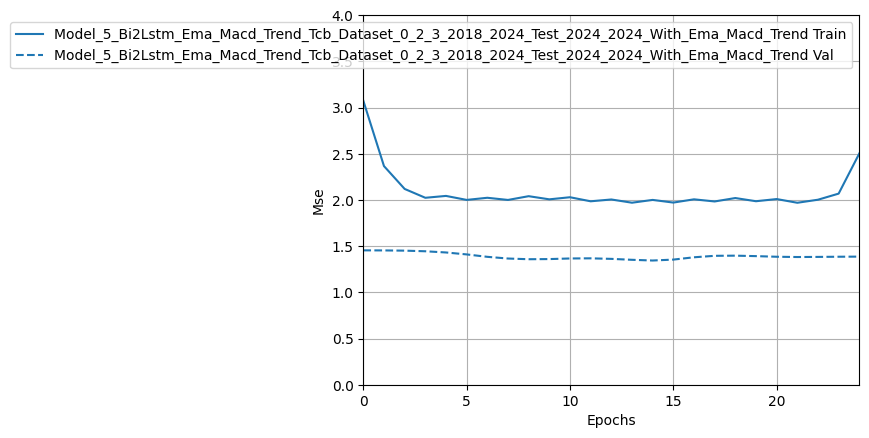

In [34]:
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,4])

In [35]:
# train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
# test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')
# for x_train, y_train, date_train in train_dataset.take(2):
#     pass
# for x_test, y_test, date_test in test_dataset.take(2):
#     pass
# plt.imshow(x_train)
# y_train
# plt.imshow(x_test)
# y_test

In [36]:
list_name_models

[]

In [37]:
dataset_folder

'../dataset/tcb_dataset_0_2_3_2018_2024_test_2024_2024_with_ema_macd_trend'